In [217]:
!pip install faiss-cpu

In [218]:
import numpy as np
from scipy import spatial 
import faiss
from time import time
import matplotlib.pyplot as plt
from collections import defaultdict

## Helper Function

In [219]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [220]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [221]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [222]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [223]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells and add the following results to the report:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [225]:
query_vectors = np.load('data/query_vectors.npy')
index_vectors = np.load('data/index_vectors.npy')
k=10
dim = index_vectors.shape[1]

In [226]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: total: 11.9 s
Wall time: 12 s


In [227]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: total: 8.23 s
Wall time: 880 ms


In [228]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: total: 859 ms
Wall time: 74 ms


In [229]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.138


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.8.

The last three bullets should also appear in the report.
You are allowed to add as many helper functions as you need. You cannot use faiss of scipy libraries for this task. Numpy is allowed. 

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:

    query_vectors = np.load('data/query_vectors2.npy')
    index_vectors = np.load('data/index_vectors2.npy')
or:

    query_vectors = np.load('data/query_vectors3.npy')
    index_vectors = np.load('data/index_vectors3.npy')
    
the aforementioned requirements should also be satisfied over these two query-index sets. No need to insert the results over these two to the report.

# Data Exploration

In [230]:
import numpy as np

# Load the data
index_vectors = np.load('data/index_vectors.npy')
query_vectors = np.load('data/query_vectors.npy')

# Check the shape of the data
print(f'Index vectors shape: {index_vectors.shape}')
print(f'Query vectors shape: {query_vectors.shape}')

# Basic statistics
print(f'Mean of index vectors: {np.mean(index_vectors, axis=0)}')
print(f'Std of index vectors: {np.std(index_vectors, axis=0)}')
print(f'Min of index vectors: {np.min(index_vectors, axis=0)}')
print(f'Max of index vectors: {np.max(index_vectors, axis=0)}')


Index vectors shape: (20000, 100)
Query vectors shape: (1000, 100)
Mean of index vectors: [0.54892402 0.58953269 0.41698616 0.51305523 0.43428859 0.56828644
 0.50170746 0.41521157 0.52465125 0.52253674 0.38360591 0.56832073
 0.49967786 0.51572299 0.44915637 0.53325511 0.52722703 0.483136
 0.56219149 0.45516991 0.37801434 0.49013022 0.33275452 0.52087558
 0.58160613 0.45264622 0.41930905 0.46142853 0.4787137  0.63665325
 0.42084995 0.52891616 0.60213212 0.3717061  0.69042201 0.46222244
 0.55067702 0.51567604 0.51070126 0.48885607 0.52145294 0.48937725
 0.41076693 0.55181521 0.36021508 0.48751546 0.53995126 0.41464778
 0.47529181 0.32520975 0.34521369 0.60569529 0.55116593 0.44482202
 0.47998671 0.51421172 0.6126775  0.46468898 0.53138677 0.53101128
 0.38019407 0.62578013 0.54957971 0.49270704 0.47745428 0.41078183
 0.63213884 0.51826831 0.63169386 0.40043927 0.56441329 0.50514545
 0.48338808 0.56817281 0.58169942 0.40773784 0.48528271 0.39611988
 0.48259593 0.53957829 0.56924239 0.51729

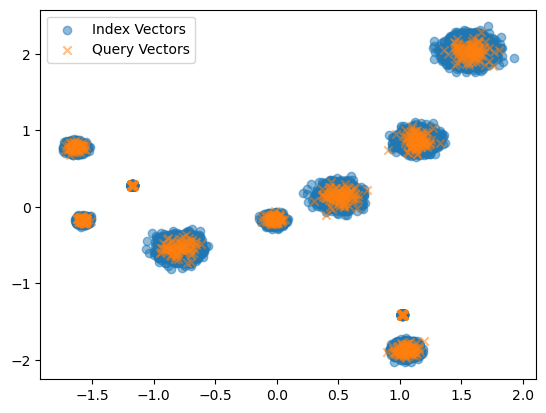

In [231]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_index_vectors = pca.fit_transform(index_vectors)
reduced_query_vectors = pca.transform(query_vectors)

# Plot the reduced vectors
plt.scatter(reduced_index_vectors[:, 0], reduced_index_vectors[:, 1], alpha=0.5, label='Index Vectors')
plt.scatter(reduced_query_vectors[:, 0], reduced_query_vectors[:, 1], alpha=0.5, label='Query Vectors', marker='x')
plt.legend()
plt.show()


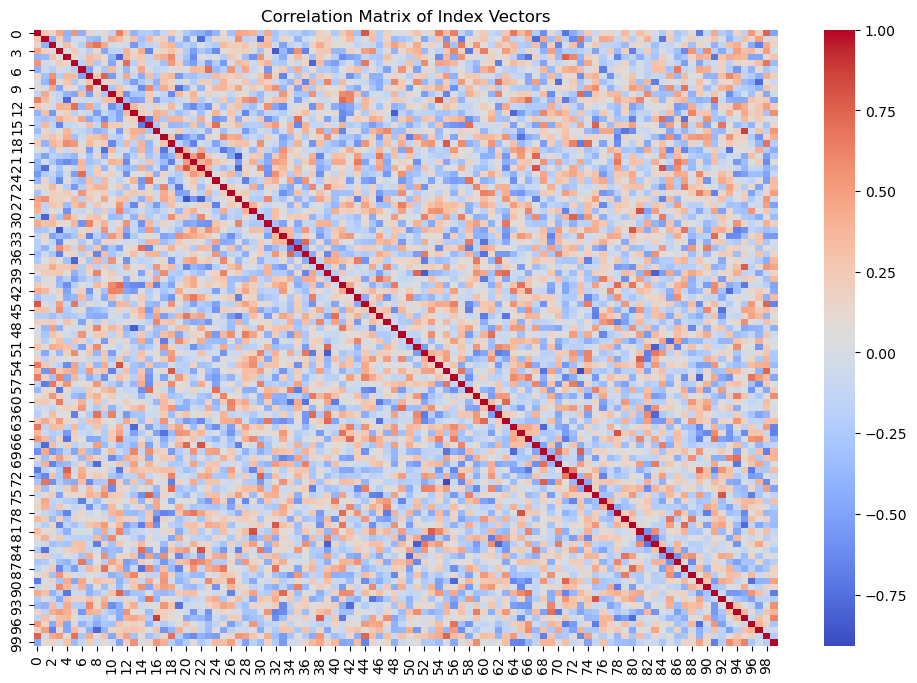

In [232]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(index_vectors)
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Index Vectors')
plt.show()


In [233]:
from scipy import stats

z_scores = np.abs(stats.zscore(index_vectors))
outliers = np.where(z_scores > 3)
print(f"Number of outliers: {len(outliers[0])}")


Number of outliers: 72


C:\Users\amirs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amirs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amirs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amirs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amirs\anaconda3\Lib\site-packages\sklearn\clust

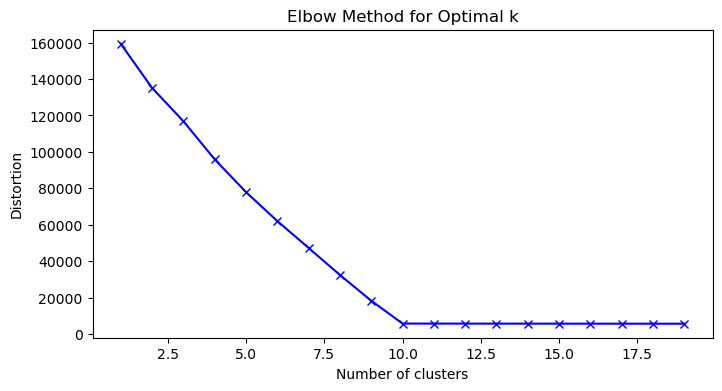

In [234]:
from sklearn.cluster import KMeans

distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(index_vectors)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()


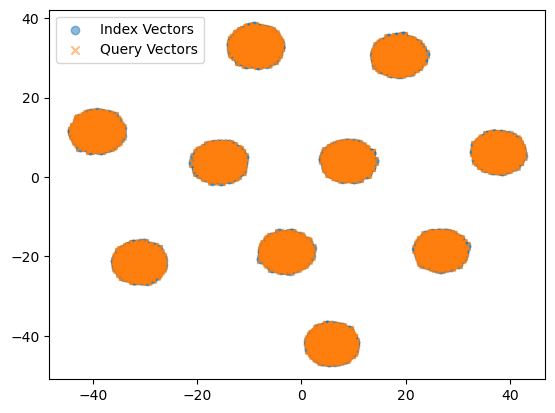

In [235]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
reduced_tsne = tsne.fit_transform(index_vectors)

plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], alpha=0.5, label='Index Vectors')
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], alpha=0.5, label='Query Vectors', marker='x')
plt.legend()
plt.show()


# 2.2.2 here

In [236]:
#TODO: Write your code for 2.2.2 here
# You are allowed to add more arguments to the functions and create more functions if needed

In [237]:
import numpy as np
from time import time

def initialize_centroids(index_vectors, num_clusters):
    """
    Initializes centroids for k-means clustering by randomly selecting vectors.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        num_clusters (int): Number of clusters to form.
    
    Returns:
        np.ndarray: Initial centroids.
    """
    return index_vectors[np.random.choice(index_vectors.shape[0], num_clusters, replace=False)]

In [238]:
def assign_clusters(index_vectors, centroids):
    """
    Assigns each vector to the nearest centroid.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        centroids (np.ndarray): Array of centroids.
    
    Returns:
        np.ndarray: Array of cluster assignments.
    """
    distances = np.linalg.norm(index_vectors[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [239]:
def update_centroids(index_vectors, clusters, num_clusters):
    """
    Updates centroids by calculating the mean of vectors in each cluster.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        clusters (np.ndarray): Array of cluster assignments.
        num_clusters (int): Number of clusters.
    
    Returns:
        np.ndarray: Updated centroids.
    """
    return np.array([index_vectors[clusters == i].mean(axis=0) for i in range(num_clusters)])

In [240]:
def kmeans_clustering(index_vectors, num_clusters, max_iters=5):
    """
    Performs k-means clustering on index vectors.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        num_clusters (int): Number of clusters.
        max_iters (int): Maximum number of iterations.
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Final centroids and cluster assignments.
    """
    centroids = initialize_centroids(index_vectors, num_clusters)
    for _ in range(max_iters):
        clusters = assign_clusters(index_vectors, centroids)
        centroids = update_centroids(index_vectors, clusters, num_clusters)
    return centroids, clusters

In [241]:
def custom_indexing_algorithm(index_vectors, num_clusters=50):
    """
    Builds an index using k-means clustering.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        num_clusters (int): Number of clusters.
    
    Returns:
        Tuple[np.ndarray, Dict[int, np.ndarray], Dict[int, np.ndarray]]: Centroids, indexed vectors, and indices.
    """
    centroids, clusters = kmeans_clustering(index_vectors, num_clusters)
    indexed_vectors = {i: index_vectors[clusters == i] for i in range(num_clusters)}
    indices = {i: np.where(clusters == i)[0] for i in range(num_clusters)}
    return centroids, indexed_vectors, indices

In [242]:
def search_within_clusters(query_vec, centroids, indexed_vectors, indices, k, num_clusters_to_search=30):
    """
    Searches for the nearest neighbors within specified clusters.
    
    Args:
        query_vec (np.ndarray): Query vector.
        centroids (np.ndarray): Array of centroids.
        indexed_vectors (Dict[int, np.ndarray]): Indexed vectors by cluster.
        indices (Dict[int, np.ndarray]): Indices of vectors by cluster.
        k (int): Number of nearest neighbors to retrieve.
        num_clusters_to_search (int): Number of clusters to search.
    
    Returns:
        np.ndarray: Indices of the k nearest neighbors.
    """
    centroid_distances = np.linalg.norm(centroids - query_vec, axis=1)
    nearest_centroids = np.argsort(centroid_distances)[:num_clusters_to_search]
    potential_neighbors = np.vstack([indexed_vectors[c] for c in nearest_centroids])
    potential_indices = np.hstack([indices[c] for c in nearest_centroids])
    distances = np.linalg.norm(potential_neighbors - query_vec, axis=1)
    nearest_neighbors = potential_indices[np.argsort(distances)[:k]]
    return nearest_neighbors

In [243]:
def custom_index_search(query_vectors, centroids, indexed_vectors, indices, k, num_clusters_to_search=30):
    """
    Performs search over the custom index.
    
    Args:
        query_vectors (np.ndarray): Array of query vectors.
        centroids (np.ndarray): Array of centroids.
        indexed_vectors (Dict[int, np.ndarray]): Indexed vectors by cluster.
        indices (Dict[int, np.ndarray]): Indices of vectors by cluster.
        k (int): Number of nearest neighbors to retrieve.
        num_clusters_to_search (int): Number of clusters to search.
    
    Returns:
        np.ndarray: Array of indices of the k nearest neighbors for each query vector.
    """
    return np.array([search_within_clusters(query_vec, centroids, indexed_vectors, indices, k, num_clusters_to_search) for query_vec in query_vectors])

In [244]:
def normalize_vectors(vectors):
    """
    Normalizes vectors to unit length.
    
    Args:
        vectors (np.ndarray): Array of vectors.
    
    Returns:
        np.ndarray: Normalized vectors.
    """
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

In [262]:
def save_the_results(num_clusters,num_clusters_to_search,recall,index_build_time,search_time,exhaustive_search_time):
        """
    Saves the results of the test run.
    
    Args:
        num_clusters (int): Number of clusters.
        num_clusters_to_search (int): Number of clusters to search.
        recall (float): Recall@10 value.
        index_build_time (float): Time taken to build the index.
        search_time (float): Time taken to search the index.
        exhaustive_search_time (float): Time taken for the exhaustive search.
    
    Returns:
        Dict[str, float]: Dictionary of results.
    """
        # Save the results
        result = {
            "num_clusters": num_clusters,
            "num_clusters_to_search": num_clusters_to_search,
            "recall": recall,
            "index_build_time": index_build_time,
            "search_time": search_time,
            "exhaustive_search_time": exhaustive_search_time
            }
        return result

In [265]:
def Print_current_results(recall,index_build_time,search_time,exhaustive_search_time):
        """
    Prints the current results of the test run.
    
    Args:
        recall (float): Recall@10 value.
        index_build_time (float): Time taken to build the index.
        search_time (float): Time taken to search the index.
        exhaustive_search_time (float): Time taken for the exhaustive search.
    """
        # Print current results
        print(f"Recall@10: {recall}")
        print(f"Index build time: {index_build_time:.4f} seconds")
        print(f"Custom search time: {search_time:.4f} seconds")
        print(f"Semi-optimized exhaustive search time: {exhaustive_search_time:.4f} seconds")
        print()

In [267]:
def Check_requirements(recall,exhaustive_search_time,index_build_time,search_time,result):
        """
    Checks if the performance requirements are met.
    
    Args:
        recall (float): Recall@10 value.
        index_build_time (float): Time taken to build the index.
        search_time (float): Time taken to search the index.
        exhaustive_search_time (float): Time taken for the exhaustive search.
        result (Dict[str, float]): Dictionary of results.
    
    Returns:
        bool: True if all requirements are met, otherwise False.
    """
        # Check if all performance requirements are met
        if (recall >= 0.8 and
            index_build_time < (0.5 * exhaustive_search_time) and
            search_time < (0.33 * exhaustive_search_time)):
            print("All performance requirements met.")
            print(result)
            return True
        return False    

In [268]:
def custom_indexing_algorithm_time(index_vectors, num_clusters=50):
    """
    Builds an index using k-means clustering.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        num_clusters (int): Number of clusters.
    
    Returns:
        Tuple[np.ndarray, Dict[int, np.ndarray], Dict[int, np.ndarray]]: Centroids, indexed vectors, indices, and index build time.
    """
    start_time = time()
    centroids, clusters = kmeans_clustering(index_vectors, num_clusters)
    indexed_vectors = {i: index_vectors[clusters == i] for i in range(num_clusters)}
    indices = {i: np.where(clusters == i)[0] for i in range(num_clusters)}
    index_build_time = time() - start_time
    return centroids, indexed_vectors, indices, index_build_time

In [269]:
def custom_index_search_time(query_vectors, centroids, indexed_vectors, indices, k, num_clusters_to_search=30):
    """
    Performs search over the custom index.
    
    Args:
        query_vectors (np.ndarray): Array of query vectors.
        centroids (np.ndarray): Array of centroids.
        indexed_vectors (Dict[int, np.ndarray]): Indexed vectors by cluster.
        indices (Dict[int, np.ndarray]): Indices of vectors by cluster.
        k (int): Number of nearest neighbors to retrieve.
        num_clusters_to_search (int): Number of clusters to search.
    
    Returns:
        np.ndarray: Array of indices of the k nearest neighbors for each query vector and search time.
    """
    start_time = time()
    res = np.array([search_within_clusters(query_vec, centroids, indexed_vectors, indices, k, num_clusters_to_search) for query_vec in query_vectors])
    search_time = time() - start_time
    return res , search_time

In [271]:
def test_hyperparameters(index_vectors, query_vectors, k, num_clusters_list, num_clusters_to_search_list):
    """
    Tests various hyperparameters for the custom index.
    
    Args:
        index_vectors (np.ndarray): Array of index vectors.
        query_vectors (np.ndarray): Array of query vectors.
        k (int): Number of nearest neighbors to retrieve.
        num_clusters_list (List[int]): List of number of clusters to test.
        num_clusters_to_search_list (List[int]): List of number of clusters to search to test.
    
    Returns:
        Tuple[List[Dict[str, float]], Dict[str, float]]: Results and optimal result.
    """
    results = []
    for num_clusters in num_clusters_list:
        for num_clusters_to_search in num_clusters_to_search_list:
            
            # Semi-optimized exhaustive search for ground truth
            start_time = time()
            nn_gt = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
            exhaustive_search_time = time() - start_time
            
            # Building custom index
            centroids, indexed_vectors, indices, index_build_time = custom_indexing_algorithm_time(index_vectors, num_clusters)
            
            # Custom index search
            custom_index_ann,search_time = custom_index_search_time(query_vectors, centroids, indexed_vectors, indices, k, num_clusters_to_search)
             
            # Compute recall@10
            recall = compute_recall_at_k(nn_gt, custom_index_ann, k)
            result = save_the_results(num_clusters,num_clusters_to_search,recall,index_build_time,search_time,exhaustive_search_time)
            results.append(result)
            #Print_current_results(recall,index_build_time,search_time,exhaustive_search_time)
            # Check if all performance requirements are met
            if Check_requirements(recall,exhaustive_search_time,index_build_time,search_time,result): 
                return results, result
    
    return results, None

In [273]:

index_vectors = np.load('data/index_vectors.npy')
query_vectors = np.load('data/query_vectors.npy')
k = 10

# Define extended hyperparameter ranges
num_clusters_list = [50, 100, 150, 200, 250]
num_clusters_to_search_list = [10, 20, 30, 40, 50]

# Test hyperparameters and print results
results, optimal_result = test_hyperparameters(index_vectors, query_vectors, k, num_clusters_list, num_clusters_to_search_list)

# Print all results
# print("All results:")
# for result in results:
#     print(result)

if optimal_result:
    print("Optimal result where all performance requirements are met:")
    print(optimal_result)
else:
    print("No combination met all performance requirements.")


All performance requirements met.
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 2.562047004699707, 'search_time': 3.286512613296509, 'exhaustive_search_time': 11.054168462753296}
Optimal result where all performance requirements are met:
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 2.562047004699707, 'search_time': 3.286512613296509, 'exhaustive_search_time': 11.054168462753296}


# testing additional two query-index set

In [278]:
# testing additional two query-index set
query_vectors2 = np.load('data/query_vectors2.npy')
index_vectors2 = np.load('data/index_vectors2.npy')

query_vectors3 = np.load('data/query_vectors3.npy')
index_vectors3 = np.load('data/index_vectors3.npy')
k = 10

# Define extended hyperparameter ranges
num_clusters_list = [50, 100, 150, 200, 250]
num_clusters_to_search_list = [10, 20, 30, 40, 50]

# Test hyperparameters and print results
results2, optimal_result2 = test_hyperparameters(index_vectors2, query_vectors2, k, num_clusters_list, num_clusters_to_search_list)

# Print all results
# print("All results:")
# for result in results:
#     print(result)

if optimal_result2:
    print("Optimal result2 where all performance requirements are met:")
    print(optimal_result2)
else:
    print("No combination 2 met all performance requirements.")
results3, optimal_result3 = test_hyperparameters(index_vectors3, query_vectors3, k, num_clusters_list, num_clusters_to_search_list)

# Print all results
# print("All results:")
# for result in results:
#     print(result)

if optimal_result3:
    print("Optimal result3 where all performance requirements are met:")
    print(optimal_result3)
else:
    print("No combination met 3 all performance requirements.")

All performance requirements met.
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 5.816011905670166, 'search_time': 6.276997327804565, 'exhaustive_search_time': 23.892899751663208}
Optimal result2 where all performance requirements are met:
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 5.816011905670166, 'search_time': 6.276997327804565, 'exhaustive_search_time': 23.892899751663208}
All performance requirements met.
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 2.9453322887420654, 'search_time': 3.4990012645721436, 'exhaustive_search_time': 11.47558856010437}
Optimal result3 where all performance requirements are met:
{'num_clusters': 50, 'num_clusters_to_search': 10, 'recall': 1.0, 'index_build_time': 2.9453322887420654, 'search_time': 3.4990012645721436, 'exhaustive_search_time': 11.47558856010437}


# 2.2.2 Final result

In [274]:
#hyperparameters
num_clusters = 50
num_clusters_to_search = 10

In [275]:
%%time
# custom_index = custom_indexing_algorithm(index_vectors, dim)

centroids, indexed_vectors, indices = custom_indexing_algorithm(index_vectors, num_clusters)

CPU times: total: 2.92 s
Wall time: 2.92 s


In [276]:

%%time
# custom_index_ann = custom_index_search(query_vectors, num_centroids ,custom_index, k)

custom_index_ann = custom_index_search(query_vectors, centroids, indexed_vectors, indices, k, num_clusters_to_search)

CPU times: total: 3.3 s
Wall time: 3.31 s


In [277]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn, custom_index_ann, k)}")

recall@10 for custom_index_search: 1.0
